# 0. Data loading

In [1]:
import pandas as pd
import numpy as np
from IPython.core.display import display, HTML
from IPython.display import Markdown, display

def printmd(string):
    display(Markdown(string))

data = pd.read_csv("data_analytics.csv")

In [2]:
data.head(1)

,Event Date,App Apple ID,Subscription Name,Standard Subscription Duration,Promotional Offer Name,Promotional Offer ID,Subscription Offer Type,Subscription Offer Duration,Marketing Opt-In Duration,Customer Currency,Proceeds Currency,Device,Country,Subscriber ID,Subscriber ID Reset,Refund,Purchase Date,Units
0,2019-07-15,1,weekly 9.99 + 7D trial,7 Days,NaN,NaN,Free Trial,7 Days,NaN,IDR,IDR,iPhone,ID,223411322456765433,NaN,NaN,NaN,1


## 1. І так, уявляю, що я Аналітик. 
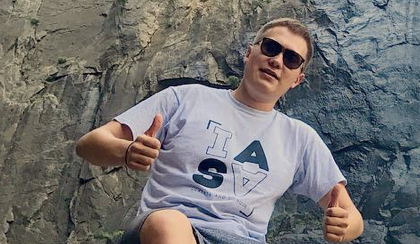

### Мені потрібно розрахувати LTV за допомогою Python.

### 1.1 Рахую виходячи з власного розуміння як це працює 

In [3]:
def calculate_user_ltv(weeks):
    price = 9.99
    apple_rate = 0.3
    # passing 1st week as it is free
    ltv = (len(weeks) - 1) * 9.99
    return ltv * (1 - apple_rate)

# ltv per user + getting mean
відповідь = data.groupby("Subscriber ID")["Subscription Offer Type"].apply(list).apply(calculate_user_ltv).mean()
printmd(f"##### Метод 1. Відповідь LTV = **{round(відповідь,3)}**")

##### Метод 1. Відповідь LTV = **9.34**

або можна взагалі в один рядок

In [4]:
# ltv per user
відповідь = data.groupby("Subscriber ID")["Subscription Offer Type"].apply(list).apply(lambda x: (len(x) - 1) * 9.99 * 0.7).mean()
printmd(f"##### Метод 2. Відповідь LTV = **{round(відповідь,3)}**")

##### Метод 2. Відповідь LTV = **9.34**

### 1.2 А потім виявилося, що у завданні навіть описано метод за яким потрібно рахувати 
###### У цьому випадку LTV рахується через конверсії з тріалу в оплату і потім в наступні оплати.
###### LTV = ([(1]+[2]+[3]+[4]+[5]), де [1] = (dev proceeds * Conversion to trial), a [2] = [1] * 1st purchase to 2nd, [3] = [2] * 2nd to 3rd i так далі.
##### Реалізуємо це в коді:

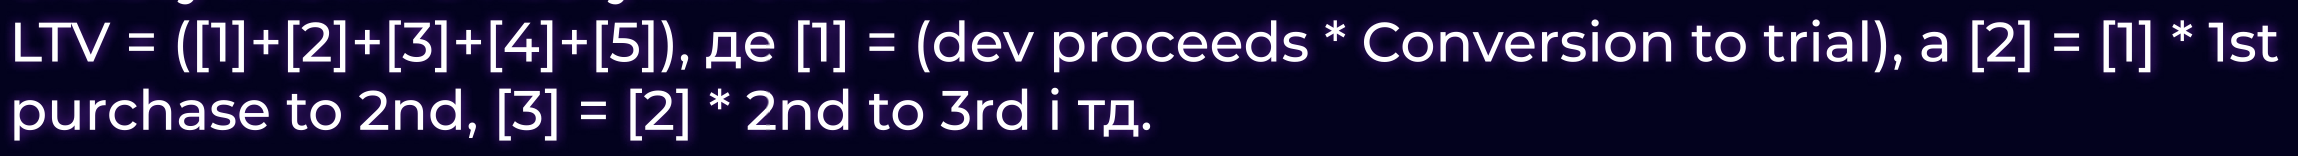

In [5]:
number_of_unique_subscribers = len(data["Subscriber ID"].unique())

tmp = data.groupby("Subscriber ID")["Subscription Offer Type"].apply(list).apply(str).value_counts()
tmp = pd.DataFrame({"values": tmp.index, "counts":tmp.values}).sort_values('values')
tmp['counts_cumsum'] = np.cumsum(tmp.counts)

In [6]:
dev_proceeds = 9.99 * (1 - 0.3)
counts = np.flip(tmp.counts_cumsum.values)

periods_res = []

for i, j in zip(counts[1:], counts[:-1]):
    conv_rate = i / j
    if len(periods_res) == 0:
        periods_res.append(dev_proceeds*conv_rate)
    else:
        periods_res.append(periods_res[-1]*conv_rate)

printmd(f"##### Метод 3. Відповідь LTV = **{round(np.sum(periods_res),3)}**")   

##### Метод 3. Відповідь LTV = **9.34**

### Ідентично те ж саме, перевірка вручну.

In [7]:
dev_proceeds = 9.99 * (1 - 0.3)

_1_ = dev_proceeds * (146+107+92+91+63)/number_of_unique_subscribers
_2_ = _1_ * (107+92+91+63)/(146+107+92+91+63)
_3_ = _2_ * (107+92+63)/(107+92+91+63)
_4_ = _3_ * (92+63)/(107+92+63)
_5_ = _4_ * (92)/(92+63)

printmd(f"##### Метод 4. Відповідь LTV = **{round(np.sum(_1_ + _2_ + _3_ + _4_ + _5_ ),3)}**")  

##### Метод 4. Відповідь LTV = **9.34**

### Вийшло таке ж значення, але чомусь мені мій метод в один рядок сподобався більше ;)